In [1046]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1047]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline

In [1048]:
class testing_model:
	def ensure_nasdaq(self, df):
		##check headdings are correct:
		if 'Date' not in df.columns:
			raise ValueError("The data does not contain the Date column.")

		if 'Open' not in df.columns:
			raise ValueError("The data does not contain the Open column.")
		
		if 'Close/Last' not in df.columns:
			raise ValueError("The data does not contain the Close/Last column.")
			
		if 'High' not in df.columns:
			raise ValueError("The data does not contain the High column.")
		
		if 'Low' not in df.columns:
			raise ValueError("The data does not contain the Low column.")

		if 'Volume' not in df.columns:
			raise ValueError("The data does not contain the Volume column.")
		
		print("Data is in the correct format and likely origins from nasdaq.com")

		return True

	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None


		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]
		return data

	def build_training(self, origindf, column, lag=5, drop=True):
		lags = lag
		names = []

		df = origindf.copy()

		for i in range(1, lags+1):
			df[f'{column}_{i}'] = df[column].shift(i)

			names.append(f'{column}_{i}')

		if drop:
			df.dropna(inplace=True)

		return df, names
	
	def prepare_data(self, raw_data, lag=2):

		## create the dataframe
		training_data = pd.DataFrame()

		## Add the known data to the dataframe
		training_data['Date'] = raw_data['Date']
		training_data['Open'] = raw_data['Open']
		training_data['Close'] = raw_data['Close/Last']

		## Add the inferred data to the dataframe
		training_data['Diff'] = raw_data['Close/Last'] - raw_data['Close/Last'].shift(1)
		training_data['Dir'] = np.where(training_data['Diff'] > 0, 1, -1)

		## build the lagged data
		training_data, close_lags = self.build_training(training_data, 'Close', lag=2, drop=False)
		training_data, open_lags = self.build_training(training_data, 'Open', lag=2, drop=False)
		training_data, diff_lags = self.build_training(training_data, 'Diff', lag=2, drop=True)

		## shift the direction column
		temp = training_data['Dir'].iloc[0]
		training_data['Dir'] = training_data['Dir'].shift(-1)
		training_data.loc[training_data.index[-1], 'Dir'] = temp


		## reset the index
		training_data = training_data.reset_index(drop=True)

		## add the constant
		training_data['Constant'] = 1.0

		return training_data, {'Close': close_lags, 'Open': open_lags, 'Diff': diff_lags}

	def __init__(self, end_classifier, open_classifier, direction_classifer, filepath, years=4):

		## set classifiers
		self.end_classifier 		= end_classifier
		self.open_classifier 		= open_classifier
		self.direction_classifier 	= direction_classifer

		## get filename from path
		self.filename = filepath.split('/')[-1].split('.')[0]

		## read in raw data
		raw_data = self.translate_data(filepath)

		## get the last x years of data
		raw_data = raw_data[raw_data['Date'] > pd.to_datetime('today') - pd.DateOffset(years=years)]
		## reset the index
		raw_data = raw_data.reset_index(drop=True)

		
		## prepare the data for splitting
		data, self.lags = self.prepare_data(raw_data, lag=2)


		## Setup easy access to needed columns
		self.searchwith = {
			'Close': ['Open'] + self.lags['Close'],
			'Open': ['Close'] + self.lags['Open'],
			'Diff': ['Diff'] + self.lags['Diff']
		}

		self.searchfor = {
			'Close': ['Close'],
			'Open': ['Open'],
			'Diff': ['Dir']
		}

		self.open_close = data[['Date'] + self.searchwith['Open'] + self.searchwith['Close']]
		self.direction 	= data[['Date'] + self.searchwith['Diff'] + self.searchfor['Diff']]

		#--/-=======================================================================================================
		##/		Train Data	|	open_close	65%
		#{<			Split	|					-> varying number of rows used to account for respective fitting
		##\					|	direction	20%
		#--\-=======================================================================================================
		self.open_close_train 	= self.open_close.iloc	[:int(len(self.open_close)*0.65)]
		self.direction_train 	= self.direction.iloc	[:int(len(self.direction)*0.20)]
		# self.direction_train 	= self.direction.iloc	[int(len(self.open_close)*0.55):int(len(self.open_close)*0.65)]

		#--/-=======================================================================================================
		##/		Test Data	|	open_close	35%
		#{<			Split	|					-> same number of rows used to allow for comparison
		##\					|	direction	35%
		#--\-=======================================================================================================
		self.open_close_test 	= self.open_close.iloc	[int(len(self.open_close)*0.65):]
		self.direction_test 	= self.direction.iloc	[int(len(self.direction)*0.65):]


		print("\nColumns in Open/Close:		", self.open_close.columns.tolist())
		print("Columns in Direction:		", self.direction.columns.tolist())

		print("\nTraining: \nClose/Open Shapes:	", self.open_close_train.shape, "Direction: ", self.direction_train.shape)
		print("\nTesting: \nClose/Open Shapes:	", self.open_close_test.shape, "Direction: ", self.direction_test.shape)

		#--/-=======================================================================================================
		##/					|	Ensuring the data
		#{<	Sanity Checks	|	is ready for training
		##\					|	and built correctly
		#--\-=======================================================================================================
		if not len(self.open_close_train) or not len(self.direction_train):
			raise ValueError("Training data is empty. Please provide more data.")
		
		if not len(self.open_close_test) or not len(self.direction_test):
			raise ValueError("Testing data is empty. Please provide more data.")
		
		if not len(self.open_close_test) == len(self.direction_test):
			raise ValueError("Testing data is not the same length. Please see configuation, predictions may not work as intended.")
		
		print("\n\nData is ready for training.")

	def train(self):
		#--/-=======================================================================================================
		##/					|	Training the models
		#{<	Training		|	the models
		##\					|	
		#--\-=======================================================================================================
		self.end_classifier.fit(		self.open_close_train[self.searchwith['Close']], 	self.open_close_train[self.searchfor['Close']])
		self.open_classifier.fit(		self.open_close_train[self.searchwith['Open']].drop(len(self.open_close_train)-1), 	self.open_close_train[self.searchfor['Open']].shift(-1).dropna())
		self.direction_classifier.fit(	self.direction_train[self.searchwith['Diff']], 		self.direction_train[self.searchfor['Diff']])

		print("\n\nModels have been trained.")

	def create_lags(self, df, column, lags=5):
		
		lag = lags
		names = []

		for i in range(1, lag+1):
			df[f'{column}_{i}'] = []
			names.append(f'{column}_{i}')

		return names
	
	def build_lags(self, df, column, buffer,row=0, lags=5):
		
		lag = lags

		print("building row: ", row, " for column: ", column)

		if row == 0:
			for i in range(1, lag+1):
				df.loc[row, f'{column}_{i}'] = buffer[(lag-i)]

		else:
			if row > lags:
				for i in range(1, lag+1):
					df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]

			else:
				for i in range(1, lag+1):

					if i <= row:
						df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]
					else:
						df.loc[row, f'{column}_{i}'] = df.loc[row-1, f'{column}_{i-1}']
			
		

		return df

	def test(self):
		#--/-=======================================================================================================
		##/					|	Testing the models
		#{<	Testing			|	the models
		##\					|	
		#--\-=======================================================================================================
		self.open_close_test['pred_Close'] 	= self.end_classifier.predict(		self.open_close_test[self.searchwith['Close']])
		self.open_close_test['pred_Open'] 	= self.open_classifier.predict(		self.open_close_test[self.searchwith['Open']])
		self.direction_test['pred_Dir'] 	= self.direction_classifier.predict(self.direction_test[self.searchwith['Diff']])

		lag=2

		test_predictions = pd.DataFrame()

		lagbuffers = {
			'Close': self.open_close_train['Open'][len(self.open_close_train)-lag:].reset_index(drop=True),
			'Open': self.open_close_train['Close'][len(self.open_close_train)-lag:].reset_index(drop=True),
			'Diff': self.direction_train['Diff'][len(self.direction_train)-lag:].reset_index(drop=True)
		}


		test_predictions['Date'] = pd.to_datetime([])
		test_predictions['Open'] = []
		open_names = self.create_lags(test_predictions, 'Open', lags=lag)
		test_predictions['Close'] = []
		close_names = self.create_lags(test_predictions, 'Close', lags=lag)
		test_predictions['Diff'] = []
		diff_names = self.create_lags(test_predictions, 'Diff', lags=lag)
		test_predictions['Dir'] = []


		next_test_date = self.open_close_train['Date'].iloc[-1] + pd.DateOffset(days=1)
		test_predictions.loc[0, 'Date'] = next_test_date


		## get the last row of the training data to predict the first row of the test data
		last_row = self.open_close_train.iloc[-1].to_frame().T.reset_index(drop=True)

		test_predictions.loc[0, 'Open'] = self.open_classifier.predict(last_row[self.searchwith['Open']])[-1]

		self.build_lags(test_predictions, 'Open', lagbuffers['Open'], row=0, lags=lag)
		self.build_lags(test_predictions, 'Close', lagbuffers['Close'], row=0, lags=lag)

		test_predictions.loc[0, 'Close'] = self.end_classifier.predict(test_predictions[self.searchwith['Close']].iloc[0].to_frame().T)[-1]

		test_predictions.loc[0, 'Diff'] = test_predictions.loc[0, 'Close'] - test_predictions.loc[0, 'Close_1']

		self.build_lags(test_predictions, 'Diff', lagbuffers['Diff'], row=0, lags=lag)

		test_predictions.loc[0, 'Dir'] = self.direction_classifier.predict(test_predictions[self.searchwith['Diff']].iloc[0].to_frame().T)[-1]


		for i in range(1, len(self.open_close_test)):
			
			test_predictions.loc[i, 'Date'] = test_predictions.loc[i-1, 'Date'] + pd.DateOffset(days=1)

			last_row = test_predictions.iloc[i-1].to_frame().T.reset_index(drop=True)

			test_predictions.loc[i, 'Open'] = self.open_classifier.predict(last_row[self.searchwith['Open']])[-1]

			self.build_lags(test_predictions, 'Open', lagbuffers['Open'], row=i, lags=lag)
			self.build_lags(test_predictions, 'Close', lagbuffers['Close'], row=i, lags=lag)

			test_predictions.loc[i, 'Close'] = self.end_classifier.predict(test_predictions[self.searchwith['Close']].iloc[i].to_frame().T)[-1]
		
			test_predictions.loc[i, 'Diff'] = test_predictions.loc[i, 'Close'] - test_predictions.loc[i, 'Close_1']

			self.build_lags(test_predictions, 'Diff', lagbuffers['Diff'], row=i, lags=lag)

			test_predictions.loc[i, 'Dir'] = self.direction_classifier.predict(test_predictions[self.searchwith['Diff']].iloc[i].to_frame().T)[-1]






		print(test_predictions)
		self.test_predictions = test_predictions



		print("\n\nModels have been tested.")
		return self.open_close_test, self.direction_test
	
	def plot_train(self):
		#--/-=======================================================================================================
		##/					|	Plotting the data
		#{<	Plotting		|	the data
		##\					|	
		#--\-=======================================================================================================
		fig, ax = plt.subplots(2, figsize=(25, 10))

		ax[0].plot(self.open_close_train['Date'], self.open_close_train['Close'], label='Close', color='red')
		ax[0].plot(self.open_close_train['Date'], self.open_close_train['Open'], label='Open', color='blue')
		ax[0].set_title("Close and Open Training Data")
		ax[0].legend()

		ax[1].plot(self.direction_train['Date'], self.direction_train['Dir'].cumsum(), label='Direction', color='green')
		ax[1].set_title("Direction Training Data")
		ax[1].legend()

		plt.show()
	
	def plot_test(self):
		#--/-=======================================================================================================
		##/					|	Plotting the data
		#{<	Plotting		|	the data
		##\					|	
		#--\-=======================================================================================================
		fig, ax = plt.subplots(4, figsize=(25, 20))




		## Daily graph
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['Open'], label='Open', color='blue')
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['Close'], label='Close', color='red')
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['pred_Open'], label='Predicted Open', color='green', linestyle='--')
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['pred_Close'], label='Predicted Close', color='yellow', linestyle='--')
		ax[0].set_title("Close and Open Price Predictions from previous day's data")
		ax[0].legend()


		ax[1].plot(self.open_close_test['Date'], self.open_close_test['Open'], label='Open Price', color='blue')
		ax[1].plot(self.open_close_test['Date'], self.test_predictions['Open'], label='Predicted Open Trend', color='green', linestyle='-.')
		ax[1].plot(self.open_close_test['Date'], self.test_predictions['Close'], label='Predicted Close Trend', color='yellow', linestyle='-.')
		ax[1].set_title("Open and Close Trend Predictions for Whole Test Data")
		ax[1].legend()


		self.direction_test['pred_strat'] = self.direction_test['pred_Dir'] * self.direction_test['Dir']
		self.direction_test['pred_return'] = self.direction_test['pred_strat'] * self.direction_test['Diff']
		## add the first value in the test data to the first value in the predictions
		self.direction_test.loc[self.direction_test.index[0], 'pred_return'] += self.open_close_test.loc[self.open_close_test.index[0], 'Open']

		ax[2].plot(self.direction_test['Date'], self.direction_test['pred_return'].cumsum(), label='Holding\'s Growth', color='yellow', linestyle='-.')
		ax[2].plot(self.open_close_test['Date'], self.open_close_test['Open'], label='Open Price', color='blue')
		ax[2].set_title("Predicted Profits for Whole Test Data")
		ax[2].legend()


		ax[3].plot(self.direction_test['Date'][:30], self.direction_test['Dir'][:30].cumsum(), label='Direction', color='green')
		ax[3].plot(self.direction_test['Date'][:30], self.direction_test['pred_Dir'][:30].cumsum(), label='Predicted Direction', color='blue', linestyle='--')
		ax[3].plot(self.direction_test['Date'][:30], self.test_predictions['Dir'][:30].cumsum(), label='Predicted Direction Trend', linestyle='-.', color='yellow')
		ax[3].set_title("Direction Predictions for first month of Test Data")
		ax[3].legend()

		plt.show()

	def show_confusion_matrix(self, cm, title, fig=None, ax=None):
		## create the heatmap of the confusion matrix
		sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)

	## configurations for the plot when not part of a subplot
		if(fig == None):

			### Set the title of the plot
			plt.title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')

			### Add Labels for the different cells of the confusion matrix
			plt.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			plt.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			plt.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			plt.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')


			### Set the ticks for the x and y axis
			plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
			plt.yticks([0.5, 1.5], ['Negative', 'Positive'])


			### Set the labels for the x and y axis
			plt.ylabel('Actual')
			plt.xlabel('Predicted')

			plt.show()
		else:

		## configurations for the plot when part of a subplot
			ax.set_title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
			ax.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			ax.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			ax.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			ax.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

			ax.set_xticks([0.5, 1.5])
			ax.set_xticklabels(['Negative', 'Positive'])
			ax.set_yticks([0.5, 1.5])
			ax.set_yticklabels(['Negative', 'Positive'])

			ax.set_ylabel('Actual')
			ax.set_xlabel('Predicted')

	def evaluate(self):
		#--/-=======================================================================================================
		##/					|	Evaluating the models
		#{<	Evaluating		|	the models
		##\					|	
		#--\-=======================================================================================================
		print("\n\nClose Model:")
		# print("Close Model Score:	", self.end_classifier.score(	self.test_predictions['Close'].to_frame().T, 	self.open_close_test[self.searchfor['Close']].shift(-1)))

		print("\n\nOpen Model:")
		# print("Open Model Score:	", self.open_classifier.score(	self.test_predictions['Open'].to_frame().T, 	self.open_close_test[self.searchfor['Open']].shift(-1).dropna()))

		print("\n\nNext day Direction Model:")
		print("Direction Model Report:	\n", classification_report(		self.direction_test[self.searchfor['Diff']], self.direction_test['pred_Dir']))
		cm = confusion_matrix(		self.direction_test[self.searchfor['Diff']], self.direction_test['pred_Dir'])
		self.show_confusion_matrix(cm, 'Direction')
		print("\n\nDirection Model Recall:	", recall_score(		self.direction_test[self.searchfor['Diff']], self.direction_test['pred_Dir']))

		print("\n\nWhole Test Prediction:")
		print("Whole Test Prediction Report:	\n", classification_report(		self.direction_test[self.searchfor['Diff']], self.test_predictions['Dir']))
		cm = confusion_matrix(		self.direction_test[self.searchfor['Diff']], self.test_predictions['Dir'])
		self.show_confusion_matrix(cm, 'Direction')

In [1049]:
test = testing_model(
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True),
	RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2,max_features='sqrt', bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, verbose=0, class_weight=None, ccp_alpha=0.025, max_samples=None),
	"csvs/stocks/amd.csv", years=8
)

Data is in the correct format and likely origins from nasdaq.com

Columns in Open/Close:		 ['Date', 'Close', 'Open_1', 'Open_2', 'Open', 'Close_1', 'Close_2']
Columns in Direction:		 ['Date', 'Diff', 'Diff_1', 'Diff_2', 'Dir']

Training: 
Close/Open Shapes:	 (1305, 7) Direction:  (401, 5)

Testing: 
Close/Open Shapes:	 (704, 7) Direction:  (704, 5)


Data is ready for training.


In [1050]:
test.train()



Models have been trained.


c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [1051]:
test.test()

C:\Users\Spoon\AppData\Local\Temp\ipykernel_32380\4103330057.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.open_close_test['pred_Close'] 	= self.end_classifier.predict(		self.open_close_test[self.searchwith['Close']])
C:\Users\Spoon\AppData\Local\Temp\ipykernel_32380\4103330057.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.open_close_test['pred_Open'] 	= self.open_classifier.predict(		self.open_close_test[self.searchwith['Open']])
C:\Users\Spoon\AppData\Local\Temp\ipykernel_32380\4

building row:  0  for column:  Open
building row:  0  for column:  Close
building row:  0  for column:  Diff
building row:  1  for column:  Open
building row:  1  for column:  Close
building row:  1  for column:  Diff
building row:  2  for column:  Open
building row:  2  for column:  Close
building row:  2  for column:  Diff
building row:  3  for column:  Open
building row:  3  for column:  Close
building row:  3  for column:  Diff
building row:  4  for column:  Open
building row:  4  for column:  Close
building row:  4  for column:  Diff
building row:  5  for column:  Open
building row:  5  for column:  Close
building row:  5  for column:  Diff
building row:  6  for column:  Open
building row:  6  for column:  Close
building row:  6  for column:  Diff
building row:  7  for column:  Open
building row:  7  for column:  Close
building row:  7  for column:  Diff
building row:  8  for column:  Open
building row:  8  for column:  Close
building row:  8  for column:  Diff
building row:  9  f

(           Date   Close  Open_1  Open_2    Open  Close_1  Close_2  pred_Close  \
 1305 2021-07-12   90.81   90.04   87.86   91.22    90.90    89.74   91.020348   
 1306 2021-07-13   90.26   91.22   90.04   90.48    90.81    90.90   90.353289   
 1307 2021-07-14   89.05   90.48   91.22   90.76    90.26    90.81   90.738953   
 1308 2021-07-15   86.93   90.76   90.48   89.78    89.05    90.26   89.841329   
 1309 2021-07-16   85.89   89.78   90.76   87.32    86.93    89.05   87.447859   
 ...         ...     ...     ...     ...     ...      ...      ...         ...   
 2004 2024-04-22  148.64  151.59  155.51  148.15   146.64   155.08  148.858482   
 2005 2024-04-23  152.27  148.15  151.59  151.65   148.64   146.64  151.460830   
 2006 2024-04-24  151.74  151.65  148.15  156.56   152.27   148.64  156.300841   
 2007 2024-04-25  153.76  156.56  151.65  149.15   151.74   152.27  148.790416   
 2008 2024-04-26  157.40  149.15  156.56  154.24   153.76   151.74  153.855325   
 
        pred_O

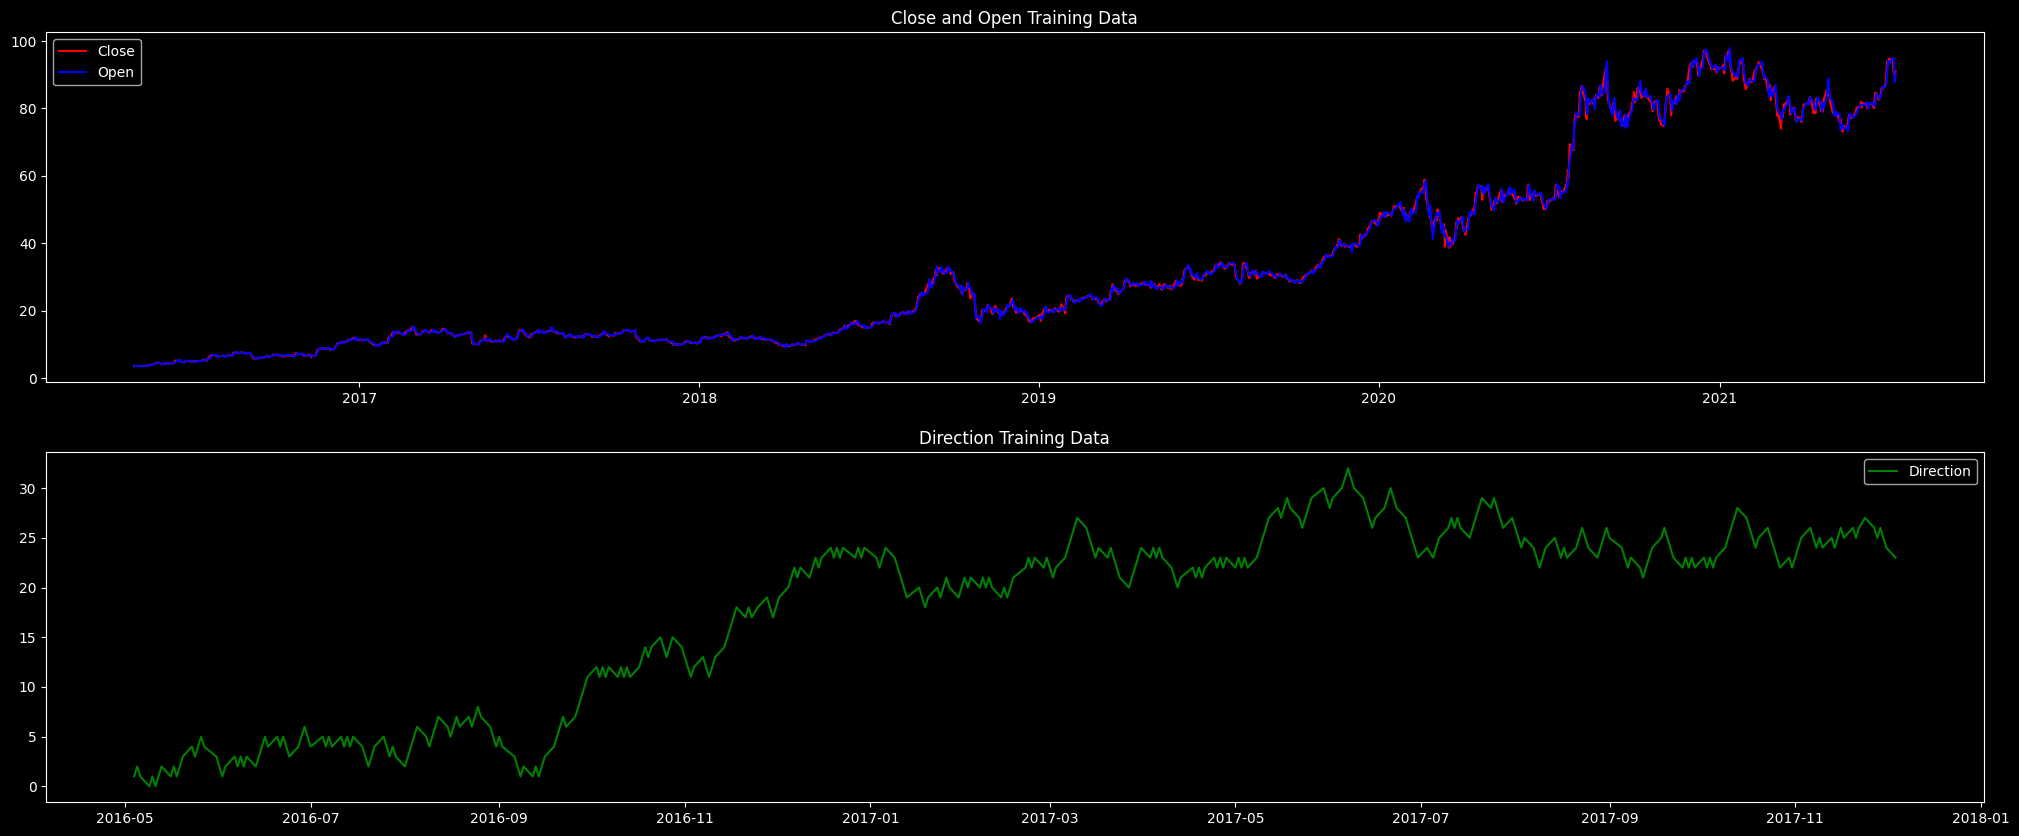

C:\Users\Spoon\AppData\Local\Temp\ipykernel_32380\4103330057.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.direction_test['pred_strat'] = self.direction_test['pred_Dir'] * self.direction_test['Dir']
C:\Users\Spoon\AppData\Local\Temp\ipykernel_32380\4103330057.py:356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.direction_test['pred_return'] = self.direction_test['pred_strat'] * self.direction_test['Diff']


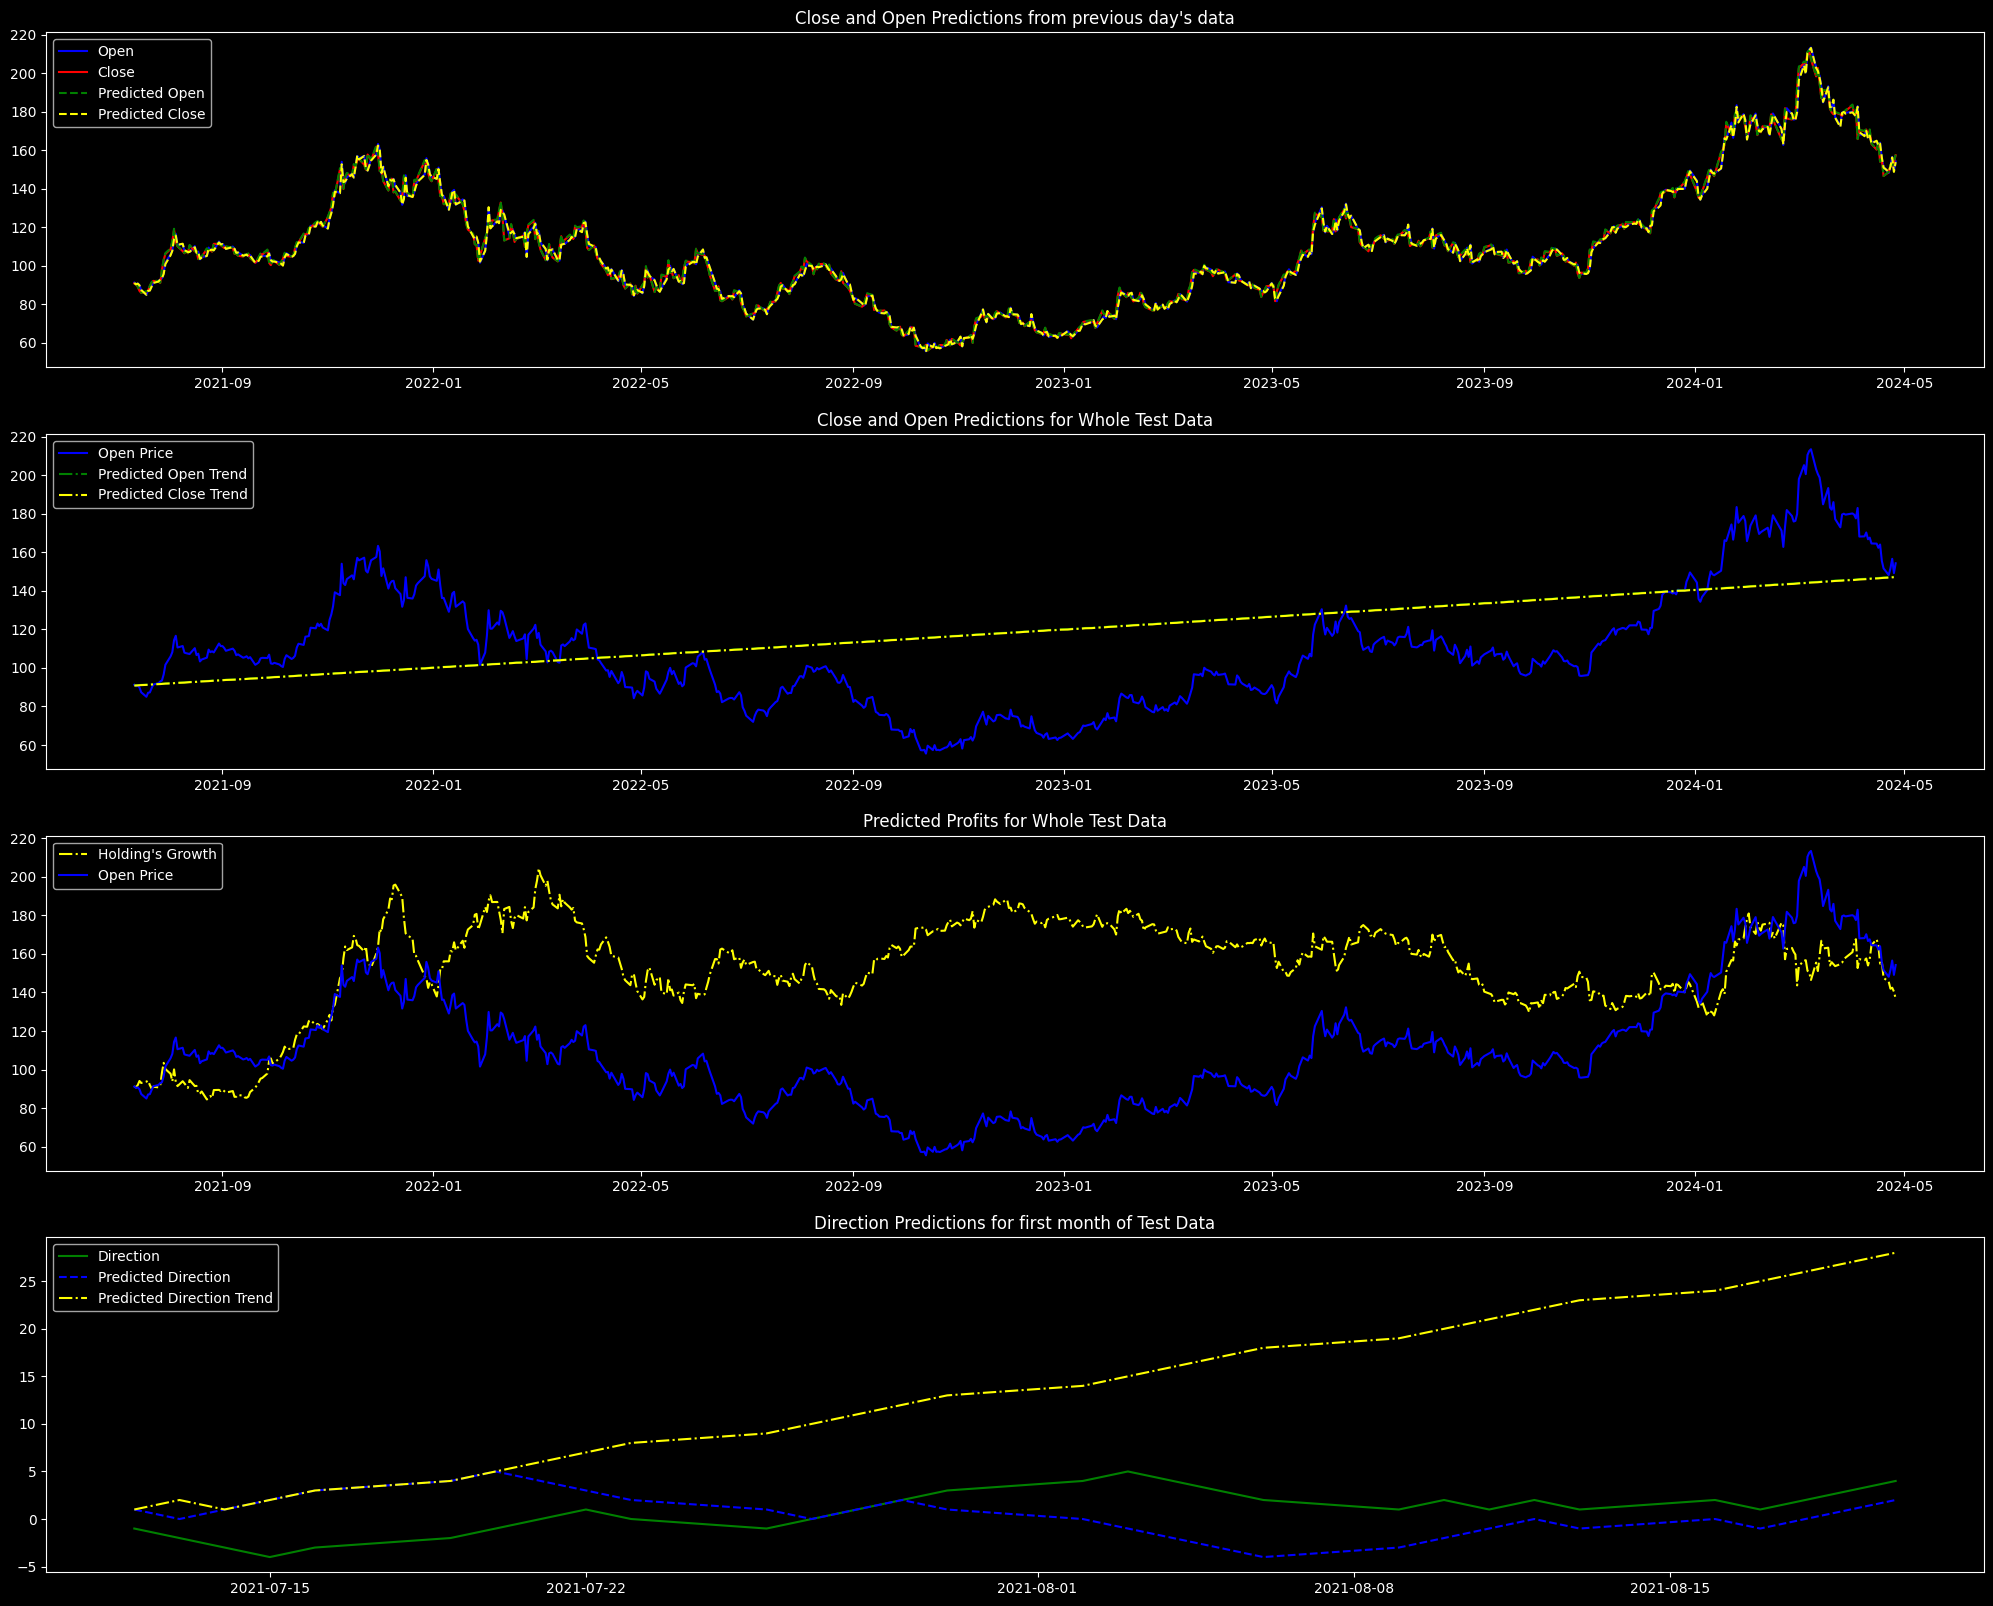

In [1052]:
test.plot_train()
test.plot_test()



Close Model:


Open Model:


Next day Direction Model:
Direction Model Report:	
               precision    recall  f1-score   support

        -1.0       0.50      0.44      0.47       357
         1.0       0.49      0.56      0.52       347

    accuracy                           0.50       704
   macro avg       0.50      0.50      0.50       704
weighted avg       0.50      0.50      0.50       704



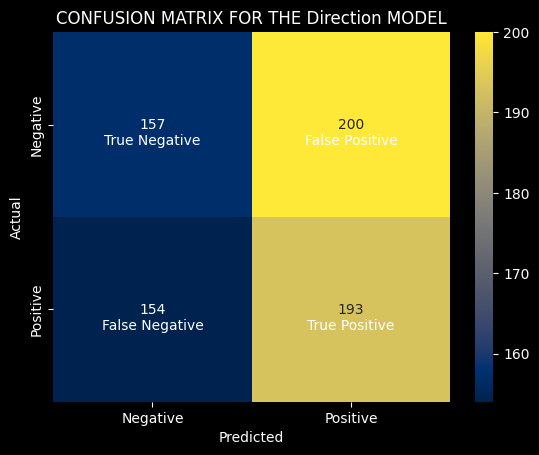



Direction Model Recall:	 0.5561959654178674


Whole Test Prediction:
Whole Test Prediction Report:	
               precision    recall  f1-score   support

        -1.0       1.00      0.00      0.01       357
         1.0       0.49      1.00      0.66       347

    accuracy                           0.49       704
   macro avg       0.75      0.50      0.33       704
weighted avg       0.75      0.49      0.33       704



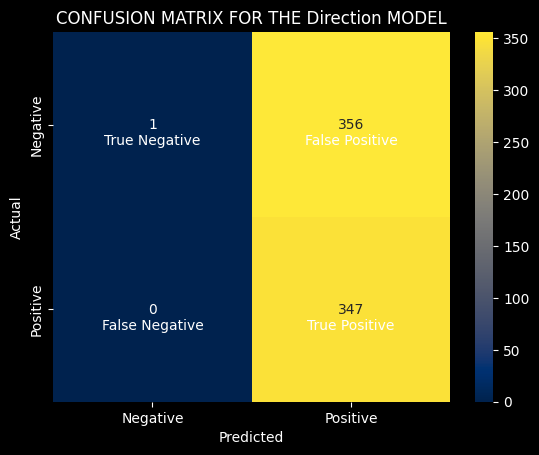

In [1053]:
test.evaluate()